In [33]:
#Generate N-Grams 

In [34]:
from collections import defaultdict
import math
import pandas as pd
import matplotlib.pyplot as plt


In [35]:
def build_ngrams(sentences, n):
    counts = defaultdict(int)
    for sentence in sentences:
        tokens = ["<s>"]*(n-1) + sentence.split() + ["</s>"]*(n-1)
        for i in range(len(tokens)-n+1):
            counts[tuple(tokens[i:i+n])] += 1
    return counts


In [36]:
def compute_prefix_T(ngram_counts):
    prefix_T = defaultdict(int)
    temp = defaultdict(set)
    for ngram in ngram_counts:
        prefix = ngram[:-1]
        temp[prefix].add(ngram[-1])
    for prefix in temp:
        prefix_T[prefix] = len(temp[prefix])
    return prefix_T


In [37]:
train_file="/home/deepakchalla/Desktop/Desktop/NLP/Lab1/train.parquet"
test_file="/home/deepakchalla/Desktop/Desktop/NLP/Lab1/test.parquet"

In [ ]:
import pyarrow.parquet as pq

def get_data(k, path, threshold=20):
    data = []
    parquet = pq.ParquetFile(path)
    for batch in parquet.iter_batches(batch_size=1000, columns=["sentence"]):
        df_batch = batch.to_pandas()
        
        for sentence in df_batch["sentence"]:
            if sentence.endswith("."):
                sentence = sentence[:-1]
            tokens = sentence.split()
            safe = True
            for token in tokens:
                if len(token) >= threshold:
                    safe = False
                    break
            if safe:   
                data.append(sentence)
            if len(data) == k:
                return data
    return data  


In [39]:
test_sentences=get_data(1000,test_file)

In [40]:
def add_one(ngram, ngram_counts, lower_counts, V):
    prefix = ngram[:-1] if len(ngram)>1 else ()
    lower = lower_counts.get(prefix, 0) if lower_counts is not None else sum(ngram_counts.values())
    count = ngram_counts.get(ngram,0)
    return math.log((count+1)/(lower+V))


In [41]:
def add_k(ngram, ngram_counts, lower_counts, V, k=0.5):
    prefix = ngram[:-1] if len(ngram)>1 else ()
    lower = lower_counts.get(prefix, 0) if lower_counts is not None else sum(ngram_counts.values())
    count = ngram_counts.get(ngram,0)
    return math.log((count+k)/(lower+k*V))


In [42]:
def token_type(ngram, ngram_counts, lower_counts, prefix_T):
    prefix = ngram[:-1] if len(ngram)>1 else ()
    lower = lower_counts.get(prefix,0) if lower_counts is not None else sum(ngram_counts.values())
    T = prefix_T.get(prefix,1)
    count = ngram_counts.get(ngram,0)
    return math.log((count+1)/(lower+T))


In [47]:
def evaluate(train, test):
    unigram_counts = build_ngrams(train,1)
    bigram_counts = build_ngrams(train,2)
    trigram_counts = build_ngrams(train,3)
    quadgram_counts = build_ngrams(train,4)
    vocab = set()
    for sentence in train:
        vocab.update(sentence.split())
    V = len(vocab)
    prefix_T_1 = compute_prefix_T(unigram_counts)
    prefix_T_2 = compute_prefix_T(bigram_counts)
    prefix_T_3 = compute_prefix_T(trigram_counts)
    prefix_T_4 = compute_prefix_T(quadgram_counts)
    results = []
    for sentence_id, sentence in enumerate(test):
        if sentence.endswith("."):
            sentence = sentence[:-1]
        tokens = sentence.split()
        for n, ngram_counts, lower_counts, prefix_T in [
            (1,unigram_counts,None,prefix_T_1),
            (2,bigram_counts,unigram_counts,prefix_T_2),
            (3,trigram_counts,bigram_counts,prefix_T_3),
            (4,quadgram_counts,trigram_counts,prefix_T_4)
        ]:
            tokens_n = ["<s>"]*(n-1)+tokens+["</s>"]*(n-1)
            logprob_1=0
            logprob_k=0
            logprob_T=0
            for i in range(len(tokens_n)-n+1):
                gram = tuple(tokens_n[i:i+n])
                lc = lower_counts if lower_counts is not None else {(): sum(unigram_counts.values())}
                logprob_1 += add_one(gram, ngram_counts, lc, V)
                logprob_k += add_k(gram, ngram_counts, lc, V, k=0.01)
                logprob_T += token_type(gram, ngram_counts, lc, prefix_T)
            results.append({
                "sentence_id":sentence_id,
                "n":n,
                "add_one_logprob":logprob_1,
                "add_k_logprob":logprob_k,
                "add_token_type_logprob":logprob_T
            })
    return pd.DataFrame(results)


In [48]:
ks=[1000,2000,5000,10000,20000,1000000]
all_results=[]
for k in ks:
    train_sentences = get_data(k,train_file)
    df = evaluate(train_sentences,test_sentences)
    df['K'] = k
    all_results.append(df)
all_results_df = pd.concat(all_results,ignore_index=True)


In [49]:
avg_logprobs = all_results_df.groupby(['K','n'])[['add_one_logprob','add_k_logprob','add_token_type_logprob']].mean().reset_index()


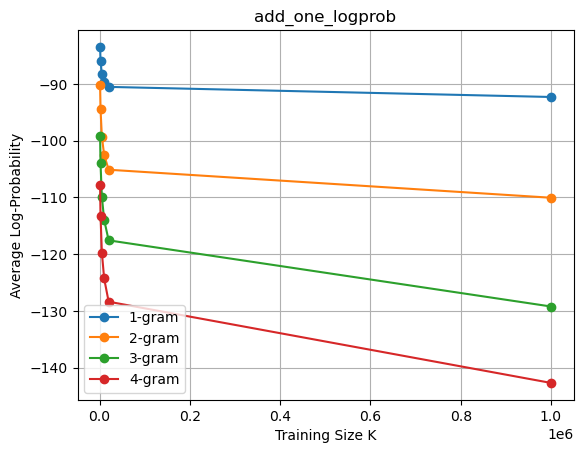

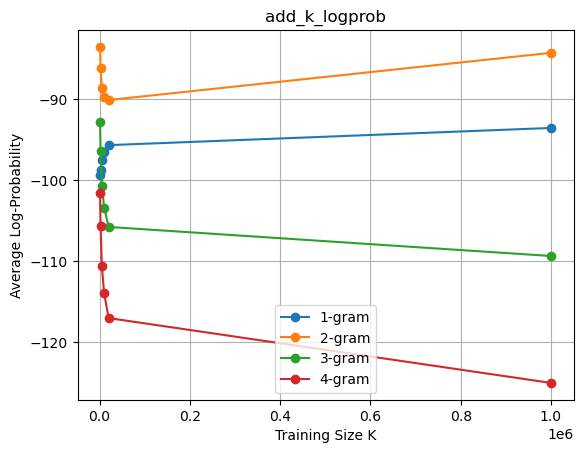

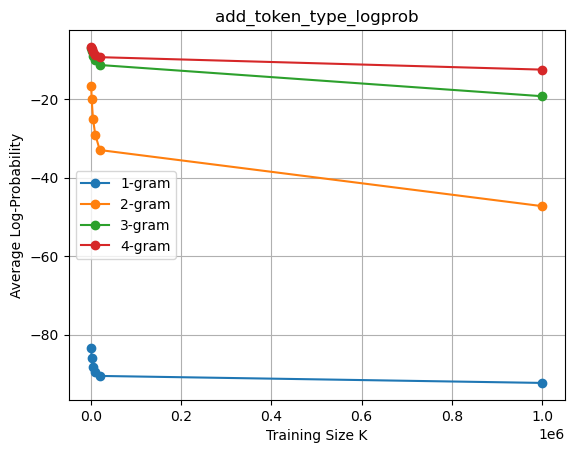

In [50]:
for smoothing in ['add_one_logprob','add_k_logprob','add_token_type_logprob']:
    plt.figure()
    for n in [1,2,3,4]:
        subset = avg_logprobs[avg_logprobs['n']==n]
        plt.plot(subset['K'],subset[smoothing],marker='o',label=f'{n}-gram')
    plt.xlabel('Training Size K')
    plt.ylabel('Average Log-Probability')
    plt.title(smoothing)
    plt.legend()
    plt.grid(True)
    plt.show()
